## PRISM Image Reconstruction Analysis Code

<b>Dan Hellfeld</b> <br>
<em>Ph.D. Student</em> | University of California, Berkeley | Department of Nuclear Engineering <br>
<em>Graduate Research Fellow</em> | Nuclear Science and Security Consortium <br>
<a href="mailto:dhellfeld@berkeley.edu">dhellfeld@berkeley.edu</a> | <a href="mailto:dhellfeld@lbl.gov">dhellfeld@lbl.gov</a> | <a href="https://dhellfeld.github.io">dhellfeld.github.io </a>

Updated: July 14, 2016 <br>
 
This code will read in output PRISM Geant4 simulation data and perform histograming, plotting, and MLEM reconstruction algorithms to produce images. This is a developing code, with many more analysis tools coming in the future.

First we will import the desired packages. The most important is the HEALPY package - documentation can be found at https://github.com/healpy/healpy.

In [1]:
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import pickle as pickle
import healpy as hp
import os.path 

## Setting up the data
Now we can read in the output data from the Geant4 simulation

In [2]:
loadfromfile = False   # use either "binary", "text", or False

if (loadfromfile == "binary"):
    dt = np.dtype([('evtN', np.uint32), ('HitNum', np.int8), ('Energy', np.float32), ('DetID', np.uint8), ('DOI', np.uint8),('HPindex', np.uint16)])
    fName = '../output/HP16Ring_DetRing_Response_100k_2152Mask.bin'
    data = np.fromfile(fName, dtype=dt)
    
elif (loadfromfile == "text"):
    # This is very out of date...

    evtN, HitNum, Energy ,DetID, DOI, HPindex = []
    
    fName = '../output/HP16Ring_DetRing_Response_20k_2152Mask.txt'
    a = np.loadtxt(fName, delimiter='\t')
    
    for i in range(0,len(a)):
        evtN.append(a[i][0])
        HitNum.append(a[i][1])
        Energy.append(a[i][2])
        DetID.append(a[i][3])
        DOI.append(a[i][4])
        HPindex.append(a[i][5])
        

Now we can create a system response matrix defined as the 2D histogram of the detector ID and HEALPix ID array in the data array.

In [3]:
NSIDE = 16    # input parameter for HEALPix, n=2,4,8,16,32,...

detbins = 192
HPbins = hp.nside2npix(NSIDE)

if (loadfromfile):
    response = (np.histogram2d(data['DetID'],data['HPindex'], bins=[detbins,HPbins], range=[[0.5,detbins+0.5],[0.5,HPbins+0.5]]))[0]
    
    # if we dont have the response saved, save it
    fName1 = "System_Responses/HP16_2152Mask_100k_Response.p"
    if not os.path.isfile(fName1):
        pickle.dump(response, open(fName1, "wb"))

else:
    fName2 = "System_Responses/HP16_2152Mask_100k_Response.p"
    response = pickle.load(open(fName2, "rb"))


Now we can plot the system matrix

<IPython.core.display.Javascript object>


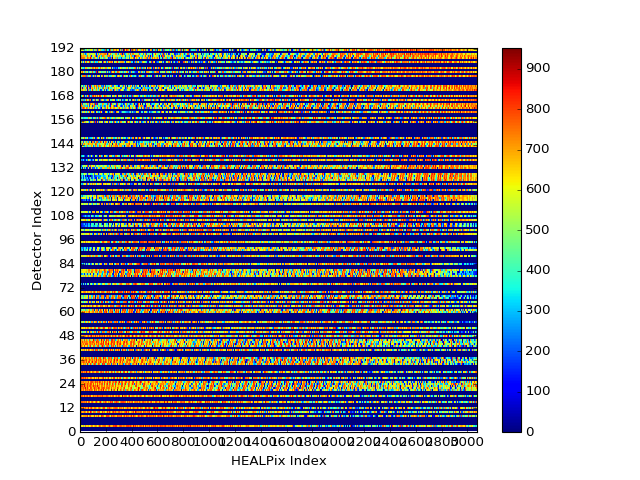

In [4]:
plt.figure(1)
im = plt.imshow(response, cmap=plt.cm.jet, origin='lower', interpolation='nearest', extent=[0.5, HPbins + 0.5, 0.5, detbins + 0.5], aspect='auto')
plt.colorbar(im)
# plt.clim(0,175)
plt.xticks(np.arange(0,HPbins+1,200))
plt.xlabel("HEALPix Index")
plt.yticks(np.arange(0,detbins+1,12))
plt.ylabel("Detector Index")


And also plot the the "autocorrelation" or the transpose of the response times the reponse.

<IPython.core.display.Javascript object>


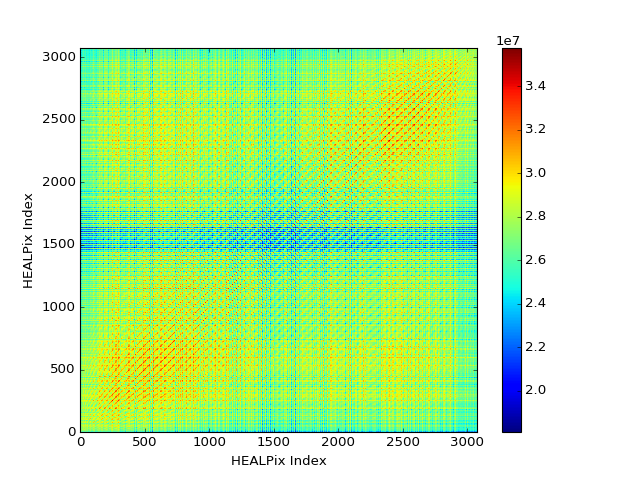

In [252]:
plt.figure(2)
autocorr = np.dot(np.transpose(response), response)
im = plt.imshow(autocorr, cmap=plt.cm.jet, origin='lower', interpolation='nearest', extent=[0.5, HPbins + 0.5, 0.5, HPbins + 0.5], aspect='auto')
plt.colorbar(im)
#plt.clim(0, 4e7)  #adjust to get better contrast
plt.xticks(np.arange(0,HPbins+1,500))
plt.xlabel("HEALPix Index")
plt.yticks(np.arange(0,HPbins+1,500))
plt.ylabel("HEALPix Index")


## Performing Maximum Likelihood Maximization Expectation (MLEM)

We first remove any empty rows from the system matrix (which will be the case for a masked detector). We then pull out a column (or two columns) of the system response to define our signal. We can then define a uniform image to begin with then run MLEM on it with our signal and response functions. 

The MLEM procedure is described by the following (Lange and Carson, 1984):

   $\lambda_j^{n+1} = \frac{\lambda_j^n}{\sum_{i\epsilon J_j}{C_{i,j}}} \sum_{i\epsilon J_j}\frac{C_{i,j}Y_i}{\sum_{k \epsilon I_i}C_{i,k}\lambda_k^n}$

where $\lambda_j^n$ is the image (with $j$ pixels) at iteration $n$, $C_{i,j}$ is the system reponse of detector pixel $i$ from image pixel $j$, and $Y_i$ is the detected signal of detector pixel $i$.

Now what I do is pull out each column of the system matrix and perform MLEM. I then store in the images in the "recon" array. This array represented the image reconstruction from a source at every HEALPix index.

In [6]:
# initialize the mlem reconstruction matrix
recon = np.zeros((HPbins, HPbins))

# Remove all the empty rows from the response matrix
response_ = response[~np.all(response == 0, axis=1)]

# Loop through all healpix angles
for i in range(0, HPbins):
#for i in range(0, 1):

    # Pull out signal
    signal  = response_[:,i]
    
    # Pull out a signal (two sources)
    #q = 1330
    #signal  = response_[:,q]
    #signal += response_[:,q-20]
    #signal /= np.sum(signal)
    
    # Pull out a signal (ring source)
    #signal = np.zeros(np.size(response_[:,1248]))
    #for i in range(0,64):
    #    signal += response_[:,(1248+i)]
    #signal /= np.sum(signal)
    
    
    # Number of iterations
    itr = 25;
    # print "\nRunning MLEM with",itr,"iterations..."

    # Initialize the image to ones
    image = np.ones(HPbins)

    # Iterate (see Lange and Carson, 1984)
    S = np.sum(response, axis=0)  # nice to have this separate, could put directly into image line though...
    for iteration in range(1, itr + 1):
        image = (image / S) * np.dot(signal / np.dot(response_, image), response_)

    # Normalize image
    image = image / np.sum(image)

    # Push image into the reconstruction matrix
    recon[i, :] = image
    

I then plot the images (1D histograms) for every HEALPix angle on one plot.

<IPython.core.display.Javascript object>


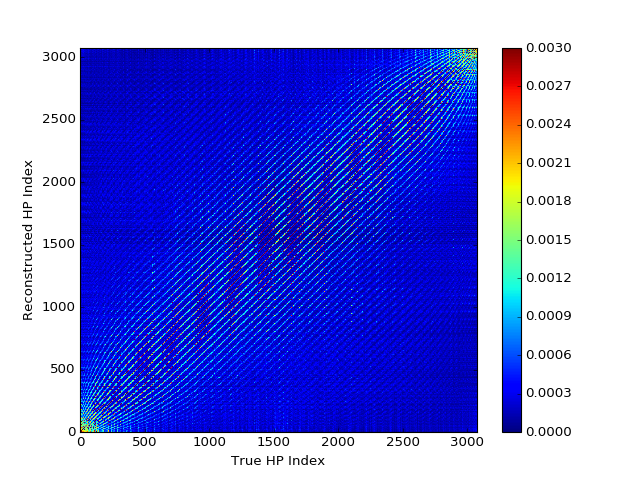

In [7]:
plt.figure(3)
im2 = plt.imshow(recon, cmap=plt.cm.jet, interpolation='nearest', origin="lower", extent=[0.5, HPbins + 0.5, 0.5, HPbins + 0.5], aspect='auto')
plt.colorbar(im2)
plt.clim(0, 0.003)  #adjust to get better contrast
plt.xlabel("True HP Index")
plt.ylabel("Reconstructed HP Index")


I can also plot these images onto the HEALPix map to give us the images on a sphere. I can then add a slider on the plot to interactively change from what HEALPix index the source originated from.

<IPython.core.display.Javascript object>


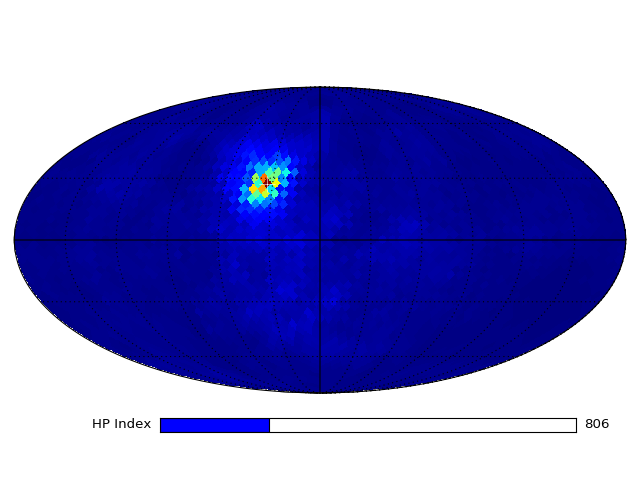

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


In [8]:
from matplotlib.widgets import Slider

hpi = np.arange(0, hp.nside2npix(NSIDE))
plt.figure(4)
hp.mollview(recon[hpi[0],:], fig=4, cbar=False, title="")
hp.projplot(hp.pix2ang(NSIDE,hpi[0]), 'w+', markersize = 15)
hp.graticule()

slider = True   #include the slider to look interactively

if slider:
    def update(val):
        hp.mollview(recon[hpi[int(shp.val)],:], fig=4, cbar=False, title="")
        hp.projplot(hp.pix2ang(NSIDE,hpi[int(shp.val)]), 'w+', markersize = 15)
        hp.graticule()
    axslide = plt.axes([0.25, 0.1, 0.65, 0.03])
    shp = Slider(axslide, "HP Index", 0, HPbins, valinit=0, valfmt="%i", dragging=True)
    shp.on_changed(update)


Or you can just print one of the images. Using the "mollzoom" function, the plot becomes interactive. Also listed are some different types of projections.

<IPython.core.display.Javascript object>


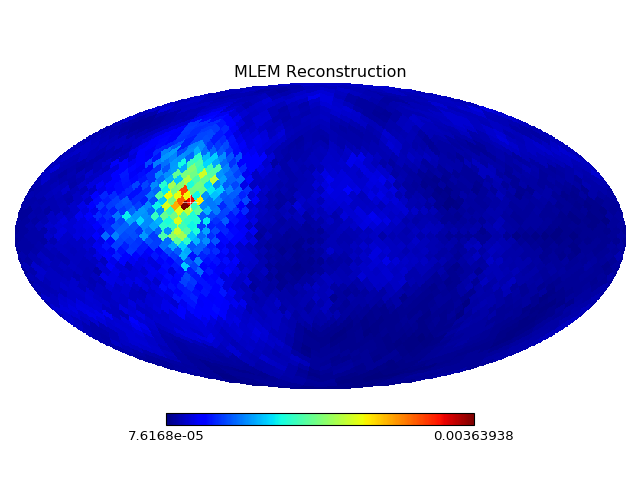

In [9]:
nside = 16
hpi_ = 1070

plt.figure(5)
#hp.orthview(recon[hpi_,:], fig=5, title="MLEM Reconstruction")
hp.mollview(recon[hpi_,:], fig=5, title="MLEM Reconstruction")
#hp.gnomview(recon[hpi_,:], fig=5, title="MLEM Reconstruction")
#hp.cartview(recon[hpi_,:], fig=5, title="MLEM Reconstruction")
#hp.mollzoom(recon[hpi_,:], fig=5, title="MLEM Reconstruction")

# Plot a white cross at the true source location
hp.projplot(hp.pix2ang(nside,hpi_), 'w+', markersize = 15)


We can also plot the sensitivty map onto the sphere

<IPython.core.display.Javascript object>


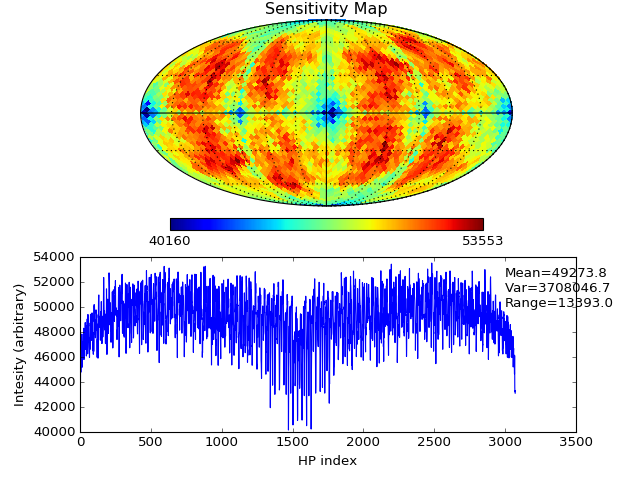

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


In [208]:
sens_mean  = S.mean()
sens_var   = S.var()
sens_range = S.ptp()

plt.figure(6)
hp.mollview(S, fig=6, cbar=True, title="Sensitivity Map", sub=211)
hp.graticule()
plt.subplot(212)
plt.plot(S)
plt.text(3000,5e4, "Mean=%.1f\nVar=%.1f\nRange=%.1f" %(sens_mean,sens_var,sens_range))
plt.xlabel("HP index")
plt.ylabel("Intesity (arbitrary)")
plt.show()

We can also plot the autocorrelation image for a given pixel. We can then correct it with the sensitivity map.

<IPython.core.display.Javascript object>


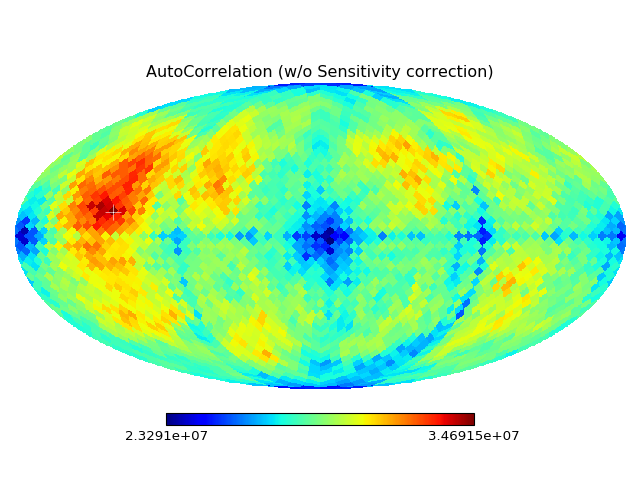

<IPython.core.display.Javascript object>


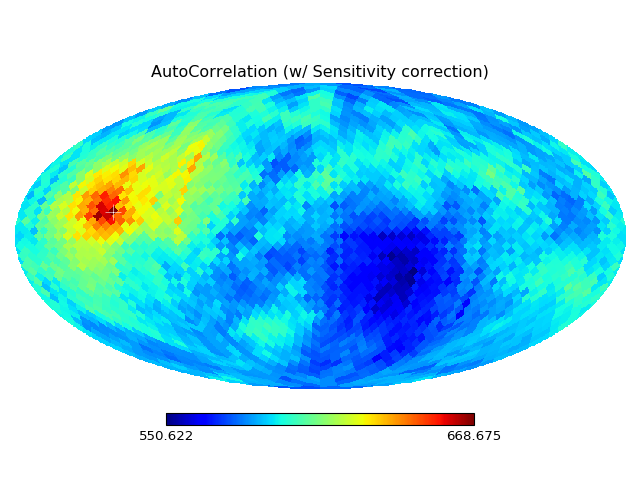

In [241]:
hpi_ = 1206

plt.figure(7)
hp.mollview(autocorr[hpi_,:],fig=7, title="AutoCorrelation (w/o Sensitivity correction)")
hp.projplot(hp.pix2ang(nside,hpi_), 'w+', markersize = 15)

plt.figure(8)
hp.mollview(autocorr[hpi_,:]/S,fig=8, title="AutoCorrelation (w/ Sensitivity correction)")
hp.projplot(hp.pix2ang(nside,hpi_), 'w+', markersize = 15)

Sensitivity correct the autocorrelation matrix we had before.

<IPython.core.display.Javascript object>


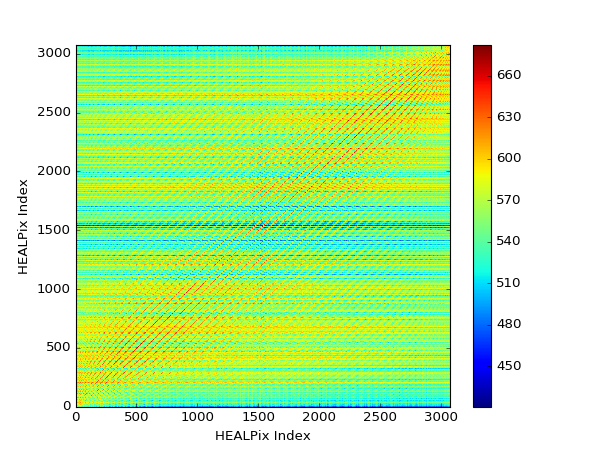

In [230]:
plt.figure(13)
im = plt.imshow(autocorr/S, cmap=plt.cm.jet, origin='lower', interpolation='nearest', extent=[0.5, HPbins + 0.5, 0.5, HPbins + 0.5], aspect='auto')
plt.colorbar(im)
plt.xticks(np.arange(0,HPbins+1,500))
plt.xlabel("HEALPix Index")
plt.yticks(np.arange(0,HPbins+1,500))
plt.ylabel("HEALPix Index")

In [7]:
# Healpix resolution
nside = 32
print hp.nside2resol(nside, arcmin=False) * (180./np.pi), "degrees"


1.83225941964 degrees


Plotting a Gaussian on the sphere

Sigma is 600.000000 arcmin (0.174533 rad) 
-> fwhm is 1412.892027 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


<IPython.core.display.Javascript object>


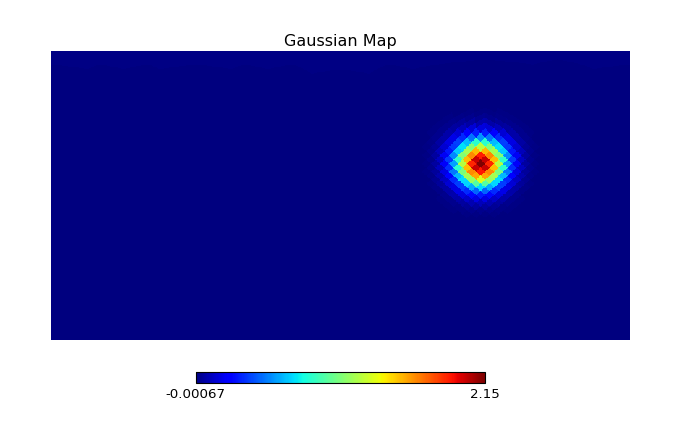

In [114]:
NSIDE = 16

m_sm=np.zeros(hp.nside2npix(NSIDE)) # create map of zeros

_hpi = 1040

m_sm[_hpi] = 100 # setting that index value to 100

gmap=hp.smoothing(m_sm, sigma=np.radians(10.)) # creating a new map with gaussian smearing

hp.cartview(gmap, title="Gaussian Map")

### Mayavi rendering for spherical heat map

Plotting the image (or whatever you'd like) on the 3D sphere.

In [98]:
from mayavi import mlab

def sphericalheatmap(nside, map_, trueindex = 1e6):
    gridsize = 1000
    theta = np.linspace(np.pi, 0, gridsize)
    phi   = np.linspace(-np.pi, np.pi, gridsize)
    
    # project the map to a rectangular matrix
    PHI, THETA = np.meshgrid(phi, theta)
    grid_pix = hp.ang2pix(nside, THETA, PHI)
    grid_map = map_[grid_pix]
    
    # Create a XYZ sphere from the theta,phi grid
    x = np.sin(THETA)*np.cos(PHI)
    y = np.sin(THETA)*np.sin(PHI)
    z = np.cos(THETA)
    
    mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(400, 300))
    mlab.clf()
    
    mp = mlab.mesh(x, y, z, scalars=grid_map, colormap="jet") 
    mlab.colorbar(mp, orientation="vertical")
    
    # Add a point to the true source location if we supply it
    if (trueindex != 1e6):
        x1,y1,z1 = hp.pix2vec(nside,1848)
        mlab.points3d(x1, y1, z1, mode="sphere", color=(1,1,1), scale_factor=0.02, resolution=20)
    
    # Plot axes (very clunky...)
    #mlab.xlabel("X", mp)
    #mlab.ylabel("Y", mp)
    #mlab.zlabel("Z", mp)
    
    # Plot a title
    mlab.text(0.005,0.05,"Spherical Heat Map")

    # animation (rotate)
    @mlab.animate(delay=60, ui=False)
    def anim():
        f = mlab.gcf()
        while 1:
            f.scene.camera.azimuth(5)
            f.scene.render()
            yield
    
    # Uncomment this line to animate the figure (it will spin in one direction right now...)
    #a = anim()     

    mlab.show()


In [253]:
nside = 16
hpi = 1848
map_ = recon[hpi,:]
#map_ = np.dot(np.transpose(response), response)[hpindex,:]/S
#map_ = S

sphericalheatmap(nside, map_, hpi)    

### VTK Rendering for spherical histogram

Create a 3D visualization to reder a 4$\pi$ image as a spherical histogram using VTK (pretty fast). We set it up by creating hexahedrons instead of cubes and then putting them into an unstructured grid. We then create one actor for the entire grid. Much better than using vtkCubeSource

In [85]:
import vtk as vtk
import matplotlib.pyplot as plt

# Function to rotate vector about Y-axis
def RotateY(pos,rad):
    x_ = pos[2]*np.sin(rad)+pos[0]*np.cos(rad)
    y_ = pos[1]
    z_ = pos[2]*np.cos(rad)-pos[0]*np.sin(rad)
    return x_,y_,z_

# Function to rotate vector about Z-axis
def RotateZ(pos,rad):
    x_ = pos[0]*np.cos(rad)-pos[1]*np.sin(rad)
    y_ = pos[0]*np.sin(rad)+pos[1]*np.cos(rad)
    z_ = pos[2]
    return x_,y_,z_

# Function to translate vector by (x,y,z)
def Translate(pos,trans):
    x_ = pos[0]+trans[0]
    y_ = pos[1]+trans[1]
    z_ = pos[2]+trans[2]
    return x_,y_,z_

# RBG array (from matplotlib)
cmap = "jet"
c_map = plt.get_cmap(cmap)
  
# Create a lookup table for colormap
lut = vtk.vtkLookupTable()
lutNum = 256
lut.SetNumberOfTableValues(lutNum)
for i in range(0,lutNum):
    lut.SetTableValue(i,c_map(i)[0],c_map(i)[1],c_map(i)[2],1.0)
    
# Create array of chars to hold colors for the hexahedrons
cubeColors = vtk.vtkUnsignedCharArray()
cubeColors.SetNumberOfComponents(3)
cubeColors.SetName("color")

# Create a renderer
renderer = vtk.vtkRenderer()
renderer.SetBackground(0.184,0.309,0.309)
#renderer.SetBackground(1,1,1)

# Define the nside for HEALPix
nside = 16

# Define what we want to look at (image, sensitivity, etc.)
hpindex = 1190
image = np.dot(np.transpose(response), response)[hpindex,:]
#image = recon[hpindex,:]
#image = S

# Scale the image to go from 0 to 1
max = np.max(image)
image /= max

# Additional scaler to contrast bins more/less
scaler = 1

# Pull out the XYZ and theta/phi coordinates for HEALPix
[x,y,z]     = hp.pix2vec(nside,range(0,hp.nside2npix(nside)))
[phi,theta] = hp.pix2ang(nside,range(0,hp.nside2npix(nside)))



# ====================================================================
# Create all the scaled/colored boxes
# ====================================================================

# Define and fill an array to hold hex points
points = vtk.vtkPoints()       
for i in range(0,hp.nside2npix(nside)):

    z_ = image[i]*scaler    
    P0= [-0.02, -0.02, 0.0]
    P1= [+0.02, -0.02, 0.0]
    P2= [+0.02, +0.02, 0.0]
    P3= [-0.02, +0.02, 0.0]
    P4= [-0.02, -0.02,  z_]
    P5= [+0.02, -0.02,  z_]
    P6= [+0.02, +0.02,  z_]
    P7= [-0.02, +0.02,  z_]
    
    # Create the points (rotate Y by phi, rotate Z by theta, translate to correct position)
    points.InsertNextPoint(Translate(RotateZ(RotateY(P0,phi[i]),theta[i]),[x[i],y[i],z[i]]))
    points.InsertNextPoint(Translate(RotateZ(RotateY(P1,phi[i]),theta[i]),[x[i],y[i],z[i]]))
    points.InsertNextPoint(Translate(RotateZ(RotateY(P2,phi[i]),theta[i]),[x[i],y[i],z[i]]))
    points.InsertNextPoint(Translate(RotateZ(RotateY(P3,phi[i]),theta[i]),[x[i],y[i],z[i]]))
    points.InsertNextPoint(Translate(RotateZ(RotateY(P4,phi[i]),theta[i]),[x[i],y[i],z[i]]))
    points.InsertNextPoint(Translate(RotateZ(RotateY(P5,phi[i]),theta[i]),[x[i],y[i],z[i]]))
    points.InsertNextPoint(Translate(RotateZ(RotateY(P6,phi[i]),theta[i]),[x[i],y[i],z[i]]))
    points.InsertNextPoint(Translate(RotateZ(RotateY(P7,phi[i]),theta[i]),[x[i],y[i],z[i]]))
    
    # Set color for this index
    r,g,b = lut.GetTableValue(int(256*image[i]))[0:3]
    cubeColors.InsertNextTupleValue((int(255*r), int(255*g),int(255*b)))
    

# Create and fill an array with the hexahedrons
theHex = []
for i in range(0,hp.nside2npix(nside)):
    theHex.append(vtk.vtkHexahedron())
    theHex[i].GetPointIds().SetNumberOfIds(8)
    for j in range(0,8):
        theHex[i].GetPointIds().SetId(j,j+(i*8)) # map internal ID (0-7) to global ID (0-npix)

# Create an unstructured grid for the hexahedrons
theGrid = vtk.vtkUnstructuredGrid()
theGrid.Allocate(hp.nside2npix(nside))
for i in range(0,hp.nside2npix(nside)):
    theGrid.InsertNextCell(theHex[i].GetCellType(), theHex[i].GetPointIds())

# Set the points
theGrid.SetPoints(points)

# Add the colors as scalars
theGrid.GetCellData().AddArray(cubeColors);
theGrid.GetCellData().SetActiveScalars("color")

# Create a mapper and actor 
theHexMapper = vtk.vtkDataSetMapper()
theHexMapper.SetInputData(theGrid)
actor = vtk.vtkActor()
actor.SetMapper(theHexMapper)

# Add to the render
renderer.AddActor(actor);

# ====================================================================


      
# Create/place a sphere behind boxes
sphere = vtk.vtkSphereSource()
sphere.SetRadius(1)
sphere.SetThetaResolution(75)
sphere.SetPhiResolution(75)
sphere_mapper = vtk.vtkPolyDataMapper()
sphere_mapper.SetInputConnection(sphere.GetOutputPort())
sphere_actor = vtk.vtkActor()
sphere_actor.SetMapper(sphere_mapper)
sphere_actor.GetProperty().SetColor(c_map(0)[0],c_map(0)[1],c_map(0)[2])
renderer.AddActor(sphere_actor) 

# Create a line pointing to the true source pixel
phi,theta = hp.pix2ang(nside,hpindex)
r_ = (1+image[i]*scaler)*5
x_ = r_ * np.cos(theta)*np.sin(phi)
y_ = r_ * np.sin(theta)*np.sin(phi)
z_ = r_ * np.cos(phi)
sourceline = vtk.vtkLineSource()
sourceline.SetPoint1(0,0,0)
sourceline.SetPoint2(x_,y_,z_)
sourceline.SetResolution(30)
linemapper = vtk.vtkPolyDataMapper()
linemapper.SetInputConnection(sourceline.GetOutputPort())
lineactor = vtk.vtkActor()
lineactor.SetMapper(linemapper)
lineactor.GetProperty().SetLineWidth(1)
lineactor.GetProperty().SetColor(0,0,0)
renderer.AddActor(lineactor)

# Create and place a title
titleActor = vtk.vtkTextActor()
titleActor.SetInput ("PRISM Spherical Histogram");
titleActor.SetPosition2 (10, 40);
titleActor.GetTextProperty().SetFontSize (20);
titleActor.GetTextProperty().SetColor (1.0, 0.0, 0.0);
renderer.AddActor2D(titleActor);

# Create a render window
render_window = vtk.vtkRenderWindow()
render_window.SetSize(800, 600)
render_window.AddRenderer(renderer)

# Create an interactor
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetRenderWindow(render_window)
style = vtk.vtkInteractorStyleTrackballCamera() 
interactor.SetInteractorStyle(style)

# Add axes to the render
axes = vtk.vtkAxesActor()
axeslength = (1+image[i]*scaler)*5
axes.SetTotalLength(axeslength,axeslength,axeslength)
axes.SetNormalizedTipLength(0,0,0)
axes.SetConeRadius(0)
renderer.AddActor(axes)

# Create a colormap legend
color_bar = vtk.vtkScalarBarWidget()
color_bar.SetInteractor(interactor)
color_bar.SetDefaultRenderer(renderer)
color_bar.SetCurrentRenderer(renderer)
color_bar.SetEnabled(True)
color_bar.GetScalarBarActor().SetLookupTable(lut)
color_bar.GetScalarBarActor().SetNumberOfLabels(5)
color_bar.GetRepresentation().SetOrientation(1)  # 0 = Horizontal, 1 = Vertical
color_bar.GetRepresentation().GetPositionCoordinate().SetValue(0.05,0.05)    # relative to window 
color_bar.GetRepresentation().GetPosition2Coordinate().SetValue(0.053,0.45)  # relative to window 

# Initialize the interactor and start the rendering loop
interactor.Initialize()
render_window.Render()
interactor.Start()


## Imaging Metrics

### Image Resolution

Lets try to fit a 2D gaussian to our images on the sphere...

### Signal to Background

...

### Peak Image to True Source (distance) metric

We can look at the "distance" from the peak image pixel (maximum intensity) to the true source pixel. This gives us an idea of the accuracy of our image. First we can look at the differnce in the HP indicies, but this does not give us a good idea becuase this can be quite large if the true pixel is close on but one or two rings away. We then look at the angular distance (in radians) between the max pixel and the true source pixel. This produces a normalized distance metric for the entire sphere.

In [143]:
import operator

nside = 16

max2true_mlem_pix      = np.zeros(hp.nside2npix(nside))
max2true_mlem_angdist  = np.zeros(hp.nside2npix(nside))
max2true_acorr_pix     = np.zeros(hp.nside2npix(nside))
max2true_acorr_angdist = np.zeros(hp.nside2npix(nside))

# Loop through all source pixels
for hpi in range(0,hp.nside2npix(nside)):
    
    # peak pixel in mlem image and autocorrelation
    maxindex_mlem = (max(enumerate(recon[hpi,:]),    key=operator.itemgetter(1)))[0]
    maxindex_acorr = (max(enumerate(autocorr[hpi,:]), key=operator.itemgetter(1)))[0]
    
    # calculate distance metric for mlem case, fill array
    max2true_mlem_pix[hpi]      = abs(maxindex_mlem - hpi)
    max2true_mlem_angdist[hpi]  = hp.rotator.angdist(hp.pix2ang(nside,maxindex_mlem),hp.pix2ang(nside,hpi))
    
    # calculate distance metric for autocorrelation case, fill array
    max2true_acorr_pix[hpi]     = abs(maxindex_acorr - hpi)
    max2true_acorr_angdist[hpi] = hp.rotator.angdist(hp.pix2ang(nside,maxindex_acorr),hp.pix2ang(nside,hpi))
    

<IPython.core.display.Javascript object>


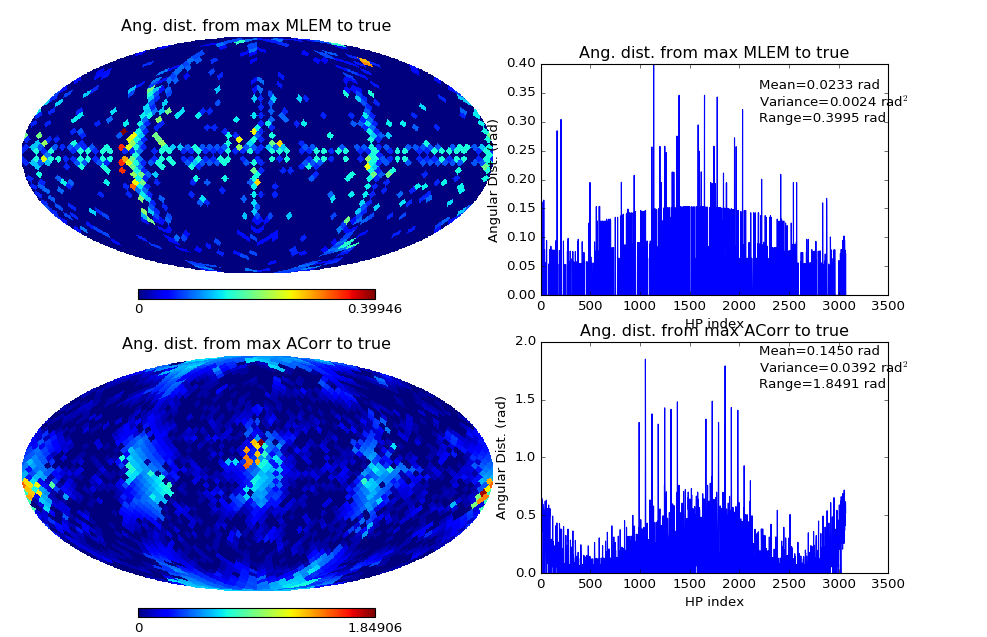

In [254]:
# Calculate mean, variance, range of the arrays
max2true_mlem_pix_mean       = max2true_mlem_pix.mean()
max2true_mlem_angdist_mean   = max2true_mlem_angdist.mean()
max2true_acorr_pix_mean      = max2true_acorr_pix.mean()
max2true_acorr_angdist_mean  = max2true_acorr_angdist.mean()
max2true_mlem_pix_var        = max2true_mlem_pix.var()
max2true_mlem_angdist_var    = max2true_mlem_angdist.var()
max2true_acorr_pix_var       = max2true_acorr_pix.var()
max2true_acorr_angdist_var   = max2true_acorr_angdist.var()
max2true_mlem_pix_range      = max2true_mlem_pix.ptp()
max2true_mlem_angdist_range  = max2true_mlem_angdist.ptp()
max2true_acorr_pix_range     = max2true_acorr_pix.ptp()
max2true_acorr_angdist_range = max2true_acorr_angdist.ptp()

# Plot in spherical heat map mode
#sphericalheatmap(nside, max2true_mlem_pix)
#sphericalheatmap(nside, max2true_mlem_angdist)
#sphericalheatmap(nside, max2true_acorr_pix)
#sphericalheatmap(nside, max2true_acorr_angdist)

# Plot in mollview with histograms to the side
plt.figure(11)
#hp.mollview(max2true_mlem_pix,      title="Difference in max MLEM image pixel index and true HP pixel index")
hp.mollview(max2true_mlem_angdist,  title="Ang. dist. from max MLEM to true",fig=11,sub=221)
#hp.mollview(max2true_acorr_pix,     title="Difference in max AutoCorrelation image pixel index and true HP pixel index")
hp.mollview(max2true_acorr_angdist, title="Ang. dist. from max ACorr to true",fig=11,sub=223)
plt.subplot(222)
plt.plot(max2true_mlem_angdist)
plt.xlabel("HP index")
plt.ylabel("Angular Dist. (rad)")
plt.title("Ang. dist. from max MLEM to true")
plt.text(2200, 0.3, 'Mean=%.4f rad\nVariance=%.4f rad$^2$\nRange=%.4f rad' % (max2true_mlem_angdist_mean,max2true_mlem_angdist_var,max2true_mlem_angdist_range))

plt.subplot(224)
plt.plot(max2true_acorr_angdist)
plt.xlabel("HP index")
plt.ylabel("Angular Dist. (rad)")
plt.title("Ang. dist. from max ACorr to true")
plt.text(2200, 1.6, 'Mean=%.4f rad\nVariance=%.4f rad$^2$\nRange=%.4f rad' % (max2true_acorr_angdist_mean,max2true_acorr_angdist_var,max2true_acorr_angdist_range))
plt.show()


### HEALPix power spectrum

... need to look into what this is actually doing and how we can use this...

<IPython.core.display.Javascript object>


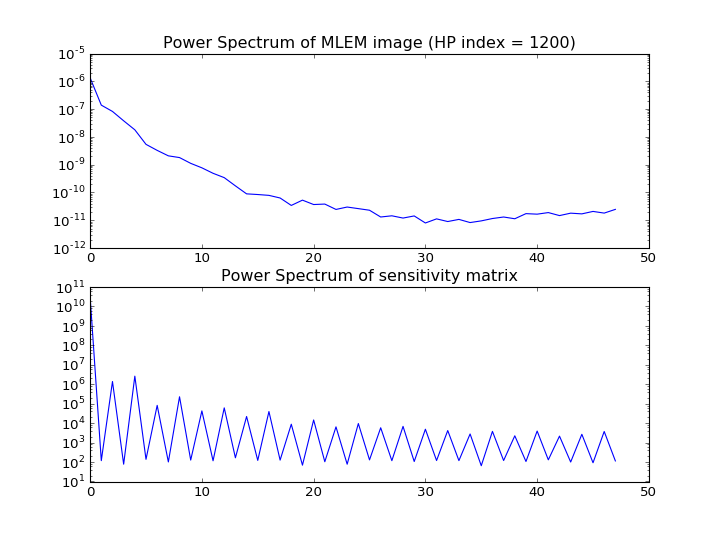

In [320]:
# Grab some image
hpi = 1200
image = recon[hpi,:]

# Plot the power spectrum of the image
plt.subplot(211)
plt.plot(hp.anafast(image))
plt.yscale('log')
plt.title("Power Spectrum of MLEM image (HP index = %i)" % hpi)


# Also plot the sensitivity power spectrum
plt.subplot(212)
plt.plot(hp.anafast(S))
plt.yscale('log')
plt.title("Power Spectrum of sensitivity matrix")

plt.show()

### Fourier transform

In this example we add three sine functions together, one with a frequency component of 50, one with 80, and one with 120, all with descreasing amplitude. We plot this function. And then we plot the Fourier transform, whichs picks out the three frequency components and their relative amplitudes.

<IPython.core.display.Javascript object>


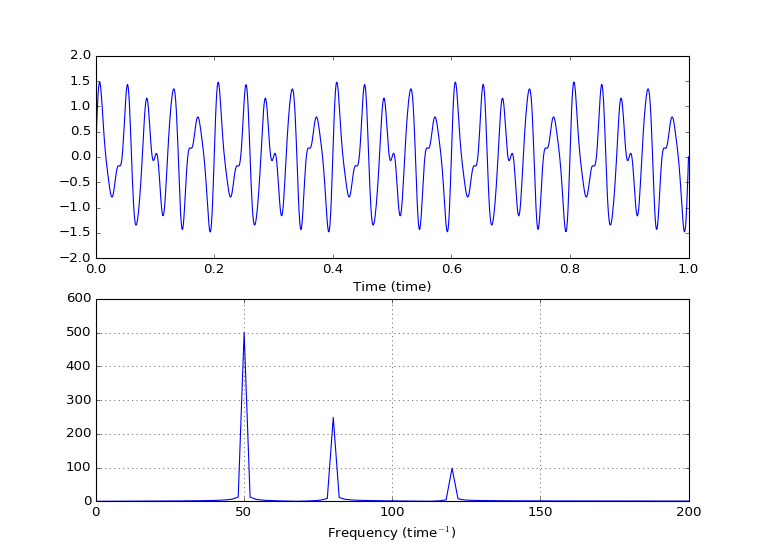

In [305]:
from scipy.fftpack import fft

# Number of points
N = 1000

x = np.linspace(0.0, 1, N)
y = np.sin(50.0*np.pi*x) + 0.5*np.sin(80.0*np.pi*x) + 0.2*np.sin(120.0*np.pi*x)

yf = fft(y)
xf = np.linspace(0.0, N, N/2)

plt.subplot(211)
plt.plot(x,y)
axes = plt.gca()
axes.set_ylim([-2,2])
plt.xlabel("Time (time)")
plt.subplot(212)
plt.plot(xf, np.abs(yf[0:N/2]))
axes = plt.gca()
axes.set_xlim([0,200])
axes.set_ylim([0,600])
plt.xlabel("Frequency (time$^{-1}$)")
plt.grid()
plt.show()
